<a href="https://colab.research.google.com/github/AashnakNishad/codsoft-/blob/main/MovieGenreClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAME**- AASHNA K NISHAD

**TITLE** - MOVIE GENRE CLASSIFICATION TASK 1

**PROBLEM STATEMENT**

Create a machine learning model that can predict the genre of a
movie based on its plot summary or other textual information. You
can use techniques like TF-IDF or word embeddings with classifiers such as Naive Bayes, Logistic Regression, or Support Vector Machines.


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aashnaknishad","key":"afbf6c372447a151ae0a2d724fed4999"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d hijest/genre-classification-dataset-imdb

Dataset URL: https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb
License(s): other
 67% 28.0M/41.7M [00:00<00:00, 156MB/s] 
100% 41.7M/41.7M [00:00<00:00, 147MB/s]


In [ ]:
! unzip /content/genre-classification-dataset-imdb.zip

Archive:  /content/genre-classification-dataset-imdb.zip
  inflating: Genre Classification Dataset/description.txt  
  inflating: Genre Classification Dataset/test_data.txt  
  inflating: Genre Classification Dataset/test_data_solution.txt  
  inflating: Genre Classification Dataset/train_data.txt  


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  # for pattern matching and text manipulation.
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
train_data = pd.read_csv("/content/Genre Classification Dataset/train_data.txt", sep=':::', names=["title", "genre", "description"], engine='python')
test_data = pd.read_csv("/content/Genre Classification Dataset/test_data.txt", sep=':::', names=["title", "description"], engine='python')

Text(0, 0.5, 'Count')

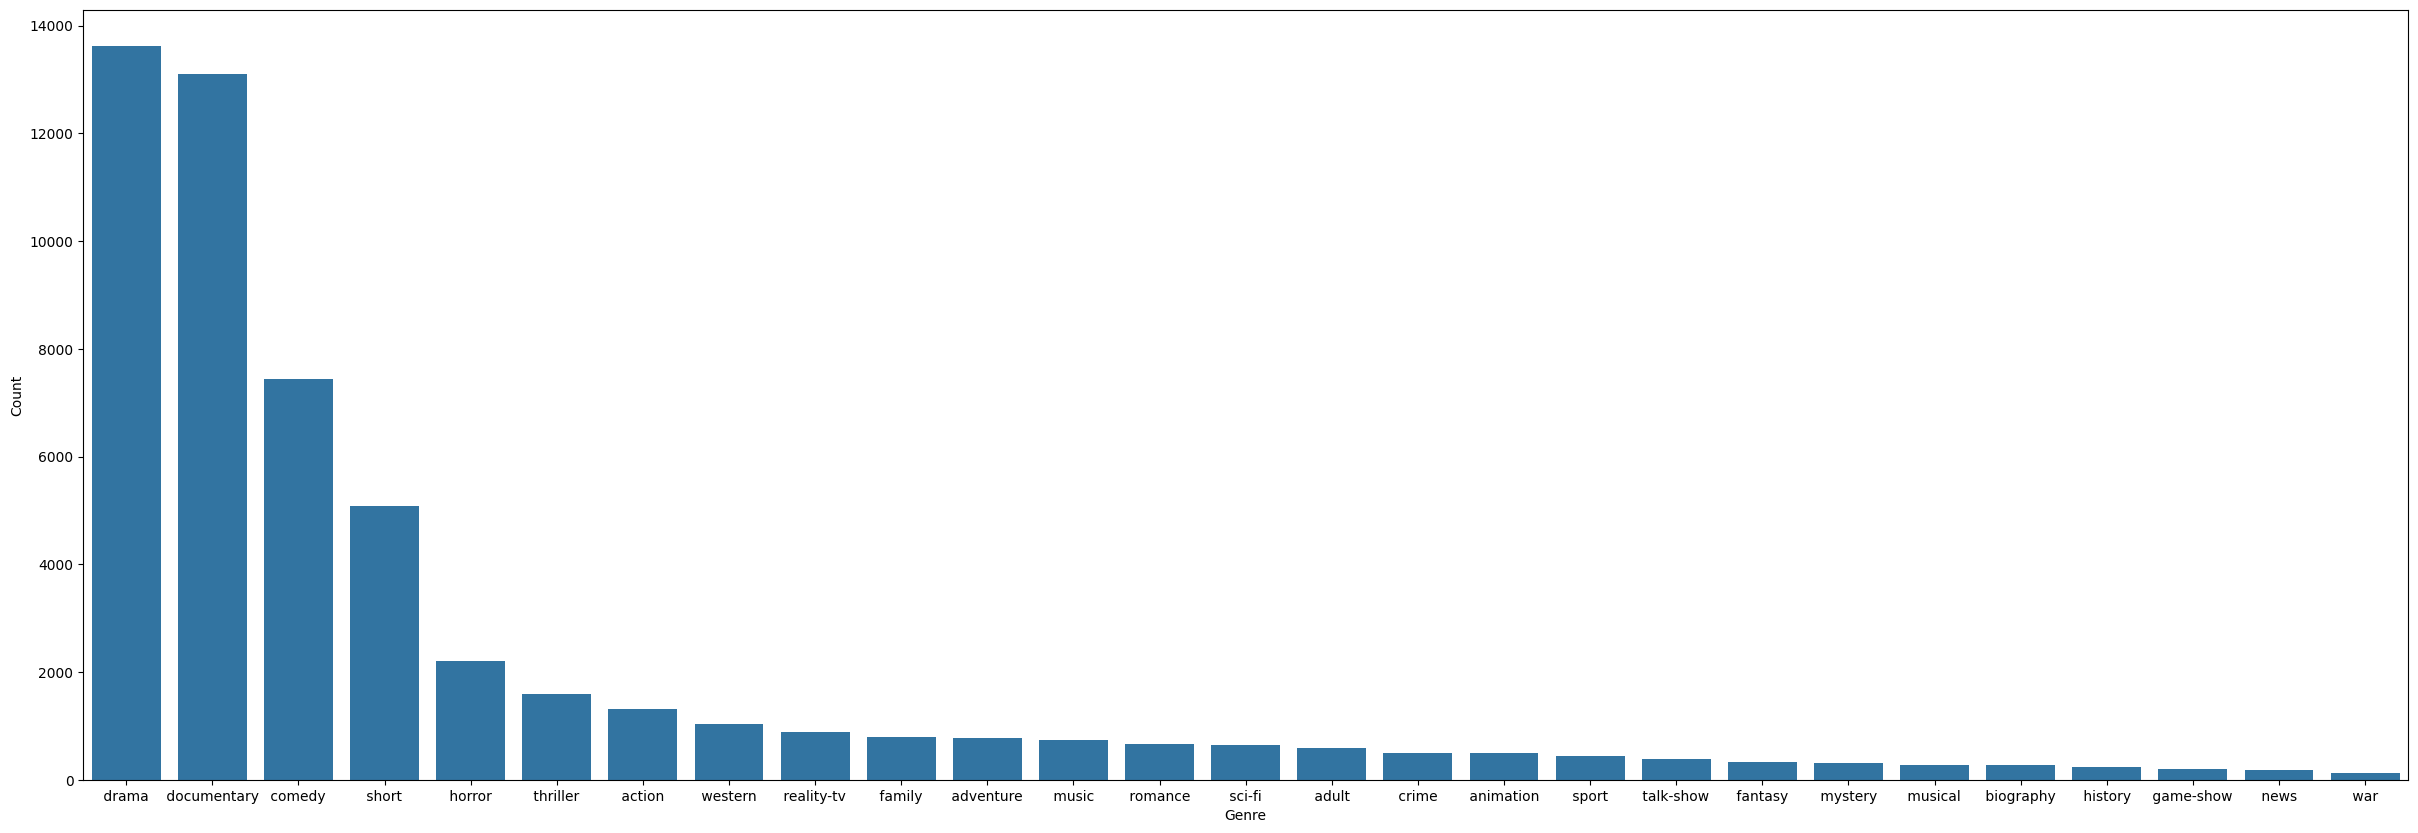

In [ ]:
plt.figure(figsize=(30,10))
counts = train_data.genre.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')

In [ ]:
train_data.isnull().sum()

,0
title,0
genre,0
description,0


In [ ]:
train_data = train_data.drop_duplicates()
train_data.shape

(54214, 3)

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))  # Stop words

def clean_data(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)                       # Remove mentions
    text = re.sub(r'http\S+', '', text)                  # Remove URLs
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)          # Remove emails
    text = re.sub(r"[^a-zA-Z+']", ' ', text)             # Keep only English chars / remove numbers
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # Remove single chars
    text = re.sub(r'pic.\S+', '', text)                   # Remove 'pic' followed by anything
    text = re.sub(r'#', "", text)                        # Remove hashtags
    text = re.sub(r"_", "  ", text)                      # Replace underscores with spaces
    text = re.sub('\n', " . ", text)                     # Remove new lines
    text = re.sub('', '', text)                   # Remove square brackets
    text = "".join([char for char in text if char not in string.punctuation]) # Remove punctuations
    text = re.sub("\s[\s]+", " ", text).strip()            # Remove repeated/leading/trailing spaces
    tokens = word_tokenize(text)                         # Tokenize
    text = " ".join([word for word in tokens if word not in stop_words and len(word) > 2]) # Remove stop words

    return text

# Apply the clean_data function to the description columns
train_data['description_cleaned'] = train_data['description'].apply(clean_data)
test_data['description_cleaned'] = test_data['description'].apply(clean_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
st = PorterStemmer()
train_data['description_cleaned'] = train_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

test_data['description_cleaned'] = test_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()]))

In [ ]:
train_data['length']=train_data['description'].apply(len)
train_data['length_cleaned']=train_data['description_cleaned'].apply(len)
train_data.head()

,title,genre,description,description_cleaned,length,length_cleaned
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listen convers doctor parent year old oscar le...,546,339
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestu relationship curre...,184,111
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bu empti student field trip museum natur histo...,650,344
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemploy father make end meet edith twin ...,1082,678
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film titl refer recov bodi ground zero also st...,625,347


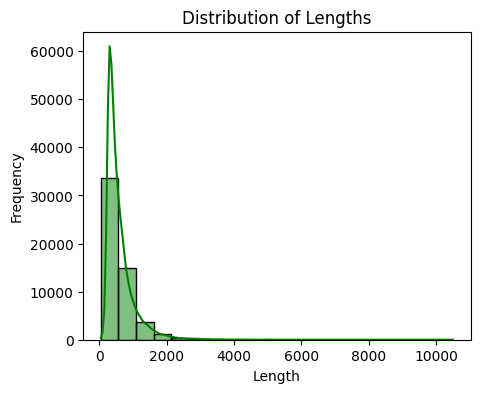

In [ ]:
plt.figure(figsize=(5,4))
sns.histplot(data=train_data, x='length', bins=20, kde=True, color='green')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths')
plt.show()

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.]),
 [Text(0.0, 0, '0'),
  Text(500.0, 0, '500'),
  Text(1000.0, 0, '1000'),
  Text(1500.0, 0, '1500'),
  Text(2000.0, 0, '2000'),
  Text(2500.0, 0, '2500'),
  Text(3000.0, 0, '3000'),
  Text(3500.0, 0, '3500'),
  Text(4000.0, 0, '4000')])

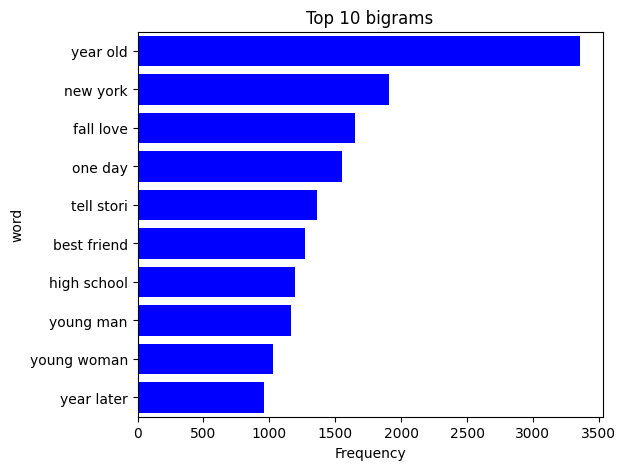

In [ ]:
common_words = get_top_n_bigram(train_data['description_cleaned'], 10)
common_words_df = pd.DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(6,5))
ax = sns.barplot(x='freq', y='word', data=common_words_df,facecolor='blue')

plt.title("Top 10 bigrams")
plt.xlabel("Frequency")
plt.yticks()
plt.xticks()

In [ ]:
le = LabelEncoder()
train_data['genre'] = le.fit_transform(train_data['genre'].values)
train_df = train_data.loc[:,['description_cleaned', 'genre']]
test_df = test_data.loc[:,['description_cleaned', 'title']]

In [ ]:
train_set , val_set , train_label , val_label = train_test_split(train_df['description_cleaned'] , train_data['genre'] , test_size=0.3 , shuffle=True , random_state = 42)

In [ ]:
vectorize = TfidfVectorizer(stop_words='english', max_features=100000)
train_set_tfidf = vectorize.fit_transform(train_set)
val_set_tfidf = vectorize.transform(val_set)

In [ ]:
#Logistic Regression
LR_model = LogisticRegression()
LR_model.fit(train_set_tfidf, train_label)
predict_LR = LR_model.predict(val_set_tfidf)
print(classification_report(val_label, predict_LR))
LR_accuracy = accuracy_score(predict_LR,val_label)
LR_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.55      0.25      0.35       398
           1       0.78      0.26      0.39       156
           2       0.45      0.14      0.21       220
           3       0.31      0.03      0.05       146
           4       0.00      0.00      0.00        88
           5       0.53      0.59      0.56      2215
           6       0.22      0.01      0.02       164
           7       0.66      0.85      0.74      3942
           8       0.54      0.80      0.64      4076
           9       0.47      0.09      0.15       218
          10       0.00      0.00      0.00       103
          11       0.96      0.42      0.58        55
          12       0.00      0.00      0.00        73
          13       0.68      0.58      0.62       626
          14       0.66      0.43      0.52       217
          15       1.00      0.01      0.03        77
          16       0.00      0.00      0.00        90
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5803873347679065

In [ ]:
#Naive Bayes classifier
NB_model = MultinomialNB()
NB_model.fit(train_set_tfidf, train_label)
y_pred_naive = NB_model.predict(val_set_tfidf)
print(classification_report(val_label, y_pred_naive))
naive_accuracy = accuracy_score(y_pred_naive,val_label)
naive_accuracy

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       398
           1       0.00      0.00      0.00       156
           2       0.00      0.00      0.00       220
           3       0.00      0.00      0.00       146
           4       0.00      0.00      0.00        88
           5       0.67      0.04      0.08      2215
           6       0.00      0.00      0.00       164
           7       0.51      0.89      0.65      3942
           8       0.38      0.87      0.53      4076
           9       0.00      0.00      0.00       218
          10       0.00      0.00      0.00       103
          11       0.00      0.00      0.00        55
          12       0.00      0.00      0.00        73
          13       0.00      0.00      0.00       626
          14       0.00      0.00      0.00       217
          15       0.00      0.00      0.00        77
          16       0.00      0.00      0.00        90
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.44027051952044266

In [ ]:
#ID3
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(train_set_tfidf, train_label)
predict_ID3 = DT.predict(val_set_tfidf)
print(classification_report(val_label, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,val_label)
ID3_accuracy

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       398
           1       0.00      0.00      0.00       156
           2       0.00      0.00      0.00       220
           3       0.00      0.00      0.00       146
           4       0.00      0.00      0.00        88
           5       0.00      0.00      0.00      2215
           6       0.00      0.00      0.00       164
           7       0.82      0.31      0.45      3942
           8       0.27      0.99      0.43      4076
           9       0.00      0.00      0.00       218
          10       0.00      0.00      0.00       103
          11       0.00      0.00      0.00        55
          12       0.00      0.00      0.00        73
          13       0.00      0.00      0.00       626
          14       0.00      0.00      0.00       217
          15       0.00      0.00      0.00        77
          16       0.00      0.00      0.00        90
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3232708269289886

In [ ]:
#Support Vector Machine
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(train_set_tfidf, train_label)
predict = svm_model.predict(val_set_tfidf)

print(classification_report(val_label, predict))
svm_accuracy = accuracy_score(predict,val_label)
svm_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.44      0.34      0.38       398
           1       0.65      0.44      0.52       156
           2       0.37      0.21      0.27       220
           3       0.35      0.12      0.17       146
           4       0.00      0.00      0.00        88
           5       0.53      0.58      0.55      2215
           6       0.21      0.04      0.07       164
           7       0.68      0.80      0.73      3942
           8       0.55      0.71      0.62      4076
           9       0.43      0.17      0.24       218
          10       0.32      0.07      0.11       103
          11       0.72      0.62      0.67        55
          12       0.00      0.00      0.00        73
          13       0.60      0.62      0.61       626
          14       0.58      0.53      0.55       217
          15       0.25      0.05      0.09        77
          16       0.00      0.00      0.00        90
          17       0.12    

0.5674146941284968

In [ ]:
columns=['LogisticRegression', 'MultinomialNB', 'Decision_Tree','SVC']
accuracy= [LR_accuracy, naive_accuracy, ID3_accuracy, svm_accuracy]
FinalResult=pd.DataFrame({'Algorithm':columns, 'Accuracy':accuracy})
FinalResult

,Algorithm,Accuracy
0,LogisticRegression,0.580387
1,MultinomialNB,0.440271
2,Decision_Tree,0.323271
3,SVC,0.567415
